In [1]:
import os
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [2]:
class PreProcessing(Dataset):
    def __init__(self, root_dir, img_size=(224, 224)):
        self.root_dir = root_dir
        self.img_size = img_size
        self.image_paths = []
        self.labels = []

        # Define class labels (Fake = 0, Real = 1)
        self.label_map = {"fake": 0, "real": 1}

        # Collect image paths and labels
        for class_name in ["fake", "real"]:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                raise ValueError(f"Error: Class folder '{class_dir}' does not exist!")

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.label_map[class_name])

        if not self.image_paths:
            raise ValueError("Error: No valid images found in the dataset folder!")

        # Define transformations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]  # Get label

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if img is None:
            raise ValueError(f"Error loading image: {img_path}")

        img = cv2.equalizeHist(img)  # Histogram equalization
        img = cv2.resize(img, self.img_size)  # Resize
        img = self.transform(Image.fromarray(img))  # Convert to tensor and normalize

        return img, torch.tensor(label, dtype=torch.long)  # Return image and label


# Define dataset paths
train_path = "IITB_total colour data of 800/train"
test_path = "IITB_total colour data of 800/test"

# Create dataset instances
train_dataset = PreProcessing(train_path)
test_dataset = PreProcessing(test_path)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset size
print(f"Training dataset size: {len(train_dataset)} images")
print(f"Testing dataset size: {len(test_dataset)} images")

# Check a batch
for batch in train_loader:
    images, labels = batch
    print("Batch shape:", images.shape)
    print("Labels:", labels)
    break


Training dataset size: 640 images
Testing dataset size: 160 images
Batch shape: torch.Size([32, 1, 224, 224])
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0])


In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from dtcwt import Transform2d

# Function to extract patches from an image
def extract_patches(image):
    height, width = image.shape

    if height < 2 or width < 2:  # Ensure image is large enough
        print("Image too small for patch extraction.")
        return None

    patch_size = (height // 2, width // 2)

    top_left = image[:patch_size[0], :patch_size[1]]
    top_right = image[:patch_size[0], width - patch_size[1]:]
    bottom_left = image[height - patch_size[0]:, :patch_size[1]]
    bottom_right = image[height - patch_size[0]:, width - patch_size[1]:]
    
    # Increase center patch size to make it more dominant
    center = image[height // 6: height - height // 6, width // 6: width - width // 6]

    patches = [top_left, top_right, bottom_left, bottom_right, center]

    # Resize patches if needed
    for i in range(len(patches)):
        if patches[i].shape != patch_size:
            patches[i] = cv2.resize(patches[i], patch_size, interpolation=cv2.INTER_AREA)

    return patches

# Define dataset paths
base_dataset_path = "IITB_total colour data of 800"
subsets = ["train", "test"]  # Process both train and test datasets
categories = ["real", "fake"]  # Two fingerprint types

# Validate dataset existence
if not os.path.exists(base_dataset_path):
    raise ValueError(f"Dataset path '{base_dataset_path}' does not exist!")

# DTCWT parameters
biort = 'near_sym_a'
qshift = 'qshift_a'
nlevels = 3
transform = Transform2d(biort=biort, qshift=qshift)

# Process images in train and test datasets
for subset in subsets:
    for category in categories:
        dataset_path = os.path.join(base_dataset_path, subset, category)

        if not os.path.exists(dataset_path):
            print(f"Skipping missing folder: {dataset_path}")
            continue

        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
        image_paths = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path) if img.lower().endswith(image_extensions)]

        if not image_paths:
            print(f"No valid images found in: {dataset_path}")
            continue

        print(f"Processing {subset}/{category}: {len(image_paths)} images")

        for img_path in image_paths:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Failed to read image: {img_path}")
                continue

            patches = extract_patches(img)

            if patches is None:
                print(f"Skipping invalid image: {img_path}")
                continue

            # Resize patches for DTCWT processing
            resized_patches = [cv2.resize(patch, (128, 128)) for patch in patches]

            # Apply DTCWT
            # Apply DTCWT
            dtcwt_patches = []
            for patch in resized_patches:
                try:
                    pyramid = transform.forward(patch, nlevels=nlevels)
                    Yl = pyramid.lowpass
                    Yh = pyramid.highpasses
                    dtcwt_patches.append((Yl, Yh))
                except Exception as e:
                    print(f"Error processing patch: {e}")
                    continue

            # Compute energy from high-frequency components of the first level
            high_freq_energy = np.mean(np.abs(Yh[0]), axis=2)
            # Normalize energy map to [0,1] range
            attention_map = (high_freq_energy - high_freq_energy.min()) / (high_freq_energy.max() - high_freq_energy.min() + 1e-8)
            # Normalize and concatenate features
            concatenated_features_list = []
            for i, (Yl, Yh) in enumerate(dtcwt_patches):
                attention_map_resized = cv2.resize(attention_map, (Yl.shape[1], Yl.shape[0]))
                attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())
                highpass_avg = np.mean(np.abs(Yh[0]), axis=2)
                highpass_resized = cv2.resize(highpass_avg, (Yl.shape[1], Yl.shape[0]))
                concatenated_features = np.stack([Yl, highpass_resized, attention_map_resized], axis=-1)
                concatenated_features = torch.tensor(concatenated_features, dtype=torch.float32)
                concatenated_features_list.append(concatenated_features)

            # Extract feature richness from high-frequency components
            features_list = []
            for Yl, Yh in dtcwt_patches:
                features = [np.sum(np.abs(subband) * (i + 1)) for i, subband in enumerate(Yh)]
                features_list.append(features)

            if features_list:
                # **Fix 1: Normalize feature richness**
                feature_richness = [np.mean(features) for features in features_list]

                # **Fix 2: Assign higher weight to center patch**
                weights = [0.5, 0.75, 1.0, 0.75, 1.2]
                weighted_features = [feature_richness[i] * weights[i] for i in range(len(features_list))]

                # **Fix 3: Edge detection to remove noisy patches**
                edges = [cv2.Canny(patch, 50, 150) for patch in patches]
                edge_strengths = [np.sum(edge) for edge in edges]
                
                # Combine edge strength and feature richness for final selection
                best_patch_index = np.argmax(weighted_features - (np.array(edge_strengths) * 0.01))  # Reduce weight of patches with high edges

                print(f"Best patch selected for {img_path}: {best_patch_index + 1}")

                # Save the best patch
                best_patch_image = resized_patches[best_patch_index]
                best_patch_save_path = os.path.join("best_patches", subset, category)
                os.makedirs(best_patch_save_path, exist_ok=True)
                best_patch_filename = os.path.join(best_patch_save_path, os.path.basename(img_path))
                cv2.imwrite(best_patch_filename, best_patch_image)

            else:
                print(f"No valid DTCWT features extracted for {img_path}.")


Processing train/real: 320 images
Best patch selected for IITB_total colour data of 800\train\real\c10_1.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c10_2.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c10_3.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c10_4.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c11_1.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c11_2.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c11_3.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c11_4.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c12_1.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c12_2.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c12_3.jpg: 5
Best patch selected for IITB_total colour data of 800\train\real\c12_4.jpg: 5
Best patch selected for IITB_t

In [ ]:
import torch
import torch.nn as nn

class MSA(nn.Module):
    def __init__(self, dim=384, num_heads=6, qkv_bias=True, attn_drop=0., proj_drop=0., return_attn=True):
        super().__init__()

        # Ensure embedding dimension is divisible by number of heads
        assert dim % num_heads == 0, 'Embedding dimension must be divisible by number of heads'

        self.dim = dim
        self.num_heads = num_heads
        self.return_attn = return_attn
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Linear layer to generate queries, keys, and values
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        
        # Attention dropout
        self.attn_drop = nn.Dropout(attn_drop)

        # Output projection layer
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):

        """
        x: Input tensor of shape (B, N, C)
           B = Batch size
           N = Sequence length (number of patches)
           C = Embedding dimension
        """
        B, N, C = x.shape

        # Compute Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv.unbind(0)  # Split into Q, K, V

        # Scale query vectors
        q = q * self.scale

        # Compute attention scores (dot product)
        attn = q @ k.transpose(-2, -1)  # (B, num_heads, N, N)

        # Softmax normalization
        attn = attn.softmax(dim=-1)

        # Apply dropout to attention weights
        attn = self.attn_drop(attn)

        # Compute attention output
        x = attn @ v  # (B, num_heads, N, head_dim)

        # Rearrange back to (B, N, C)
        x = x.transpose(1, 2).reshape(B, N, C)

        # Final projection
        x = self.proj(x)
        x = self.proj_drop(x)

        # Return both output and attention map (if required)
        if self.return_attn:
            return x, attn
        else:
            return x


In [5]:
import torch
import torch.nn as nn

class LivenessClassifier(nn.Module):
    def __init__(self, input_dim=224, num_classes=2, return_attn=True):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, 384)  # Ensure C = 384
        self.msa = MSA(dim=384, num_heads=6, return_attn=return_attn)
        self.return_attn = return_attn

        self.fc1 = nn.Linear(384, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):

        B = x.shape[0]  # Get batch size

        x = self.input_proj(x)  # Ensure correct embedding dimension, Should be (B, N, 384)

        x = x.reshape(B, -1, 384)  # Automatically infer sequence length N, Should be (B, N, 384)

        x, attn = self.msa(x) if self.return_attn else (self.msa(x), None)

        x = x.mean(dim=1)  # Average pooling
        x = self.relu(self.bn1(self.fc1(x)))
        #self.input_proj = nn.Linear(224, 384) 
        x = self.fc2(x)

        return (x, attn) if self.return_attn else x


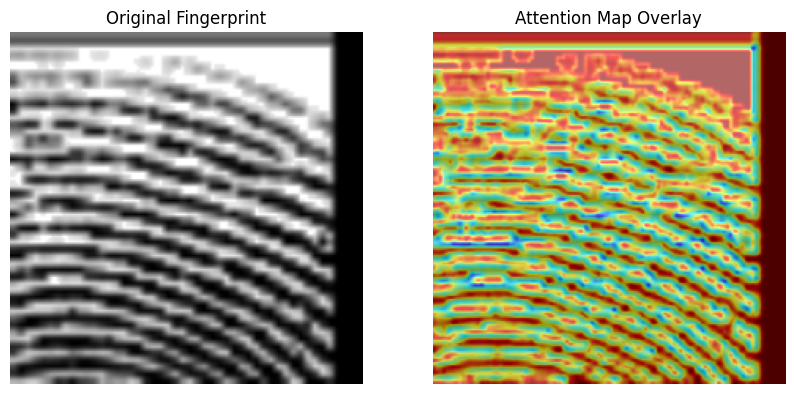

In [6]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pywt

class PreProcessing(Dataset):
    def __init__(self, root_folder, img_size=(224, 224)):
        self.root_folder = root_folder
        self.img_size = img_size

        if not os.path.exists(root_folder):
            raise ValueError(f"Error: Dataset path '{root_folder}' does not exist!")

        self.image_paths = []
        self.labels = []

        for label, category in enumerate(["fake", "real"]):
            folder_path = os.path.join(root_folder, category)
            if not os.path.exists(folder_path):
                raise ValueError(f"Error: '{category}' folder is missing in '{root_folder}'")

            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    self.image_paths.append(os.path.join(folder_path, img_name))
                    self.labels.append(label)

        if not self.image_paths:
            raise ValueError("Error: No valid images found in the dataset!")

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1]
        ])

    def __len__(self):
        return len(self.image_paths)  # This should return the actual dataset size

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]  # 0 = Fake, 1 = Real

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Error loading image: {img_path}")

        img = cv2.equalizeHist(img)
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))  # Corrected order

        img = np.uint8(img)  # Ensure it's in uint8 format before ToTensor
        tensor_img = self.transform(img)

        return tensor_img, label


# Set dataset paths
train_path = "best_patches/train"
test_path = "best_patches/test"

# Load datasets with collate function
train_dataset = PreProcessing(train_path)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load a shuffled batch
batch = next(iter(train_loader))
tensor_imgs, labels = batch

# Convert first image in the batch for visualization
first_img = tensor_imgs[0].numpy().squeeze()
first_img = (first_img - first_img.min()) / (first_img.max() - first_img.min() + 1e-8)
first_img = (first_img * 255).astype(np.uint8)

# Apply wavelet transform to get high-frequency components (this was missing)
coeffs = pywt.wavedec2(first_img, 'db1', level=1)
cA, (cH, cV, cD) = coeffs  # Approximation, Horizontal, Vertical, Diagonal
Yh = [(cH, cV, cD)]  # High-frequency coefficients

# Compute energy from high-frequency components of the first level
high_freq_energy = np.mean(np.abs(np.array([cH, cV, cD])), axis=0)
# Normalize energy map to [0,1] range
attention_map = (high_freq_energy - high_freq_energy.min()) / (high_freq_energy.max() - high_freq_energy.min() + 1e-8)

def visualize_attention(fingerprint_image, attention_map, alpha=0.6):
    if fingerprint_image is None:
        raise ValueError("Error: Fingerprint image is not loaded!")
    
    attention_map = cv2.resize(attention_map, (fingerprint_image.shape[1], fingerprint_image.shape[0]))
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)
    
    fingerprint_colored = cv2.cvtColor(fingerprint_image, cv2.COLOR_GRAY2RGB)
    heatmap = cv2.applyColorMap((attention_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    overlay = cv2.addWeighted(fingerprint_colored, 1 - alpha, heatmap, alpha, 0)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(fingerprint_image, cmap="gray")
    axs[0].set_title("Original Fingerprint")
    axs[0].axis("off")
    
    axs[1].imshow(overlay)
    axs[1].set_title("Attention Map Overlay")
    axs[1].axis("off")
    
    plt.show()

# Load a sample image from the dataset
sample_idx = 7  # Change index as needed
sample_image, _ = train_dataset[sample_idx]  # Assuming your dataset returns (image, label)

# Convert to numpy array and normalize if needed
sample_image = sample_image.numpy().squeeze()
sample_image = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min() + 1e-8)
sample_image = (sample_image * 255).astype(np.uint8)

# Calculate wavelet coefficients for the sample image
sample_coeffs = pywt.wavedec2(sample_image, 'db1', level=1)
sample_cA, (sample_cH, sample_cV, sample_cD) = sample_coeffs
sample_high_freq_energy = np.mean(np.abs(np.array([sample_cH, sample_cV, sample_cD])), axis=0)
sample_attention_map = (sample_high_freq_energy - sample_high_freq_energy.min()) / (sample_high_freq_energy.max() - sample_high_freq_energy.min() + 1e-8)

# Visualize attention with the correct attention map for the sample image
visualize_attention(sample_image, sample_attention_map)

Epoch [1/15] - Train Loss: 0.9962, Train Acc: 0.9141 - Val Loss: 1.6202, Val Acc: 0.9625
Epoch [2/15] - Train Loss: 1.7926, Train Acc: 0.9297 - Val Loss: 0.4583, Val Acc: 0.9375
Epoch [3/15] - Train Loss: 0.8880, Train Acc: 0.9125 - Val Loss: 0.8927, Val Acc: 0.8938
Epoch [4/15] - Train Loss: 1.7072, Train Acc: 0.6906 - Val Loss: 0.5212, Val Acc: 0.8562
Epoch [5/15] - Train Loss: 0.3745, Train Acc: 0.9078 - Val Loss: 0.2216, Val Acc: 0.9187
Epoch [6/15] - Train Loss: 0.1277, Train Acc: 0.9391 - Val Loss: 0.1738, Val Acc: 0.9688
Epoch [7/15] - Train Loss: 0.0823, Train Acc: 0.9672 - Val Loss: 0.1834, Val Acc: 0.9563
Epoch [8/15] - Train Loss: 0.1421, Train Acc: 0.9609 - Val Loss: 0.2268, Val Acc: 0.9500
Epoch [9/15] - Train Loss: 0.0723, Train Acc: 0.9719 - Val Loss: 0.0772, Val Acc: 0.9750
Epoch [10/15] - Train Loss: 0.1215, Train Acc: 0.9656 - Val Loss: 0.1137, Val Acc: 0.9625
Epoch [11/15] - Train Loss: 0.0935, Train Acc: 0.9688 - Val Loss: 0.1805, Val Acc: 0.9437
Epoch [12/15] - Tra

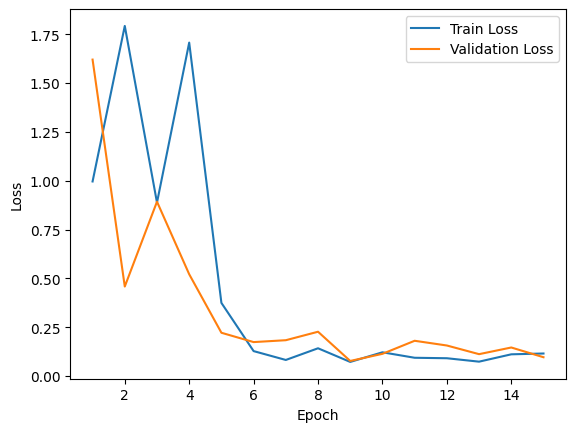

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move to device
model = LivenessClassifier(num_classes=2, return_attn=False).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.2, weight_decay=0)

# Training parameters
num_epochs = 15  # Adjust based on dataset size
train_losses = []
val_losses = []

# Train and test datasets
train_path = "best_patches/train"
test_path = "best_patches/test"

train_dataset = PreProcessing(train_path)
test_dataset = PreProcessing(test_path)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():  # No gradient calculation for validation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

   
# Save the trained model
torch.save(model.state_dict(), "liveness_model.pth")

# Plot loss curves
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Evaluating model on test set...


Testing: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]



Test Accuracy: 97.50%

Classification Report:
               precision    recall  f1-score   support

        Real     0.9634    0.9875    0.9753        80
        Fake     0.9872    0.9625    0.9747        80

    accuracy                         0.9750       160
   macro avg     0.9753    0.9750    0.9750       160
weighted avg     0.9753    0.9750    0.9750       160


Class-Specific Metrics:
✔ Real (Live) - Precision: 0.9634, Recall: 0.9875, F1-Score: 0.9753
✔ Fake - Precision: 0.9872, Recall: 0.9625, F1-Score: 0.9747

Confusion Matrix:
 [[79  1]
 [ 3 77]]


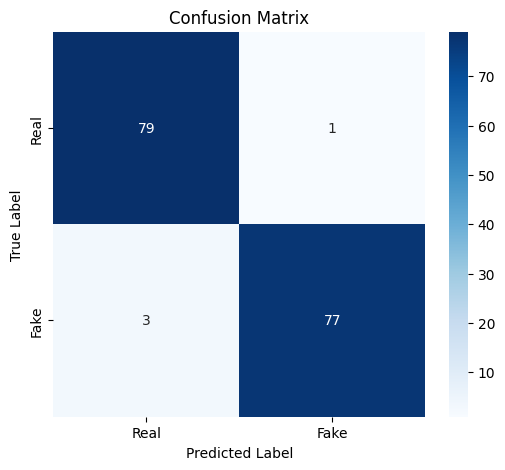

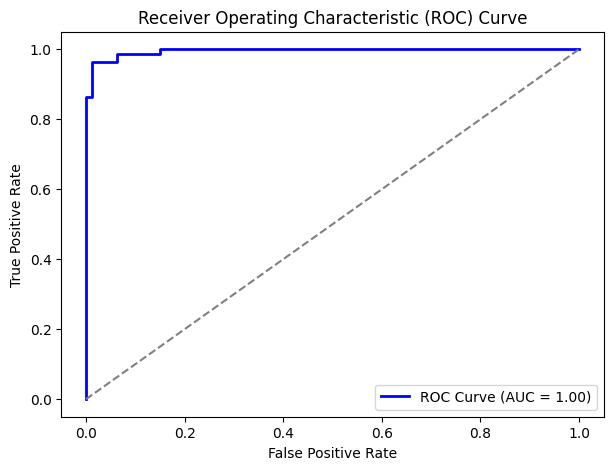


Equal Error Rate (EER): 0.0250


In [8]:
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve
)


# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LivenessClassifier(num_classes=2, return_attn=False).to(device)
model.load_state_dict(torch.load("liveness_model.pth", map_location=device))
model.eval()

# Load test dataset
test_path = "best_patches/test"
test_dataset = PreProcessing(test_path)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize evaluation variables
all_preds, all_labels = [], []
all_probs = []  # For ROC curve
correct, total = 0, 0

print("\nEvaluating model on test set...")
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probabilities for positive class
        predictions = outputs.argmax(dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# **Overall Test Accuracy**
test_acc = correct / total * 100
print(f"\nTest Accuracy: {test_acc:.2f}%")

# **Classification Report (Includes Precision, Recall, F1-score, and Support)**
report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"], digits=4)
print("\nClassification Report:\n", report)

# **Class-Specific Metrics Calculation**
precision_real = precision_score(all_labels, all_preds, pos_label=0)
recall_real = recall_score(all_labels, all_preds, pos_label=0)
f1_real = f1_score(all_labels, all_preds, pos_label=0)

precision_fake = precision_score(all_labels, all_preds, pos_label=1)
recall_fake = recall_score(all_labels, all_preds, pos_label=1)
f1_fake = f1_score(all_labels, all_preds, pos_label=1)

print(f"\nClass-Specific Metrics:")
print(f"✔ Real (Live) - Precision: {precision_real:.4f}, Recall: {recall_real:.4f}, F1-Score: {f1_real:.4f}")
print(f"✔ Fake - Precision: {precision_fake:.4f}, Recall: {recall_fake:.4f}, F1-Score: {f1_fake:.4f}")

# **Confusion Matrix**
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", cm)

# **Plot Confusion Matrix**
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **ROC Curve and AUC Score**
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

'''# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)  # AUC for PR curve

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
'''

# **Equal Error Rate (EER) Calculation**
fnr = 1 - tpr  # False Negative Rate
abs_diff = np.abs(fpr - fnr)
eer_index = np.argmin(abs_diff)
eer = (fpr[eer_index] + fnr[eer_index]) / 2

print(f"\nEqual Error Rate (EER): {eer:.4f}")